# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Лабораторная работа №2. Кластерный анализ. </center>

## Задание 1

В данном задании вам необходимо реализовать алгоритм кластеризации [Partition Around Medoids](http://algowiki-project.org/ru/%D0%A3%D1%87%D0%B0%D1%81%D1%82%D0%BD%D0%B8%D0%BA:Denemmy/Partitioning_Around_Medoids_%28%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%29).  
  
Два возможных варианта реализации:  
  
### Функция
  
Нужно написать функцию, которая принимает на вход несколько параметров и возвращает также несколько значений.  
  
Параметры функции:
- **data:** данные в виде dataframe или матрицы (аналогично функциям и методам, которые рассматривали на практике);
- **k:** число центров (кластеров);
- **metric:** расстояние между объектами (те же, что поддерживает функция `pdist()`);
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.

Возвращаемые значения:  
- **inertia:** итоговое значение целевой функции;
- **medoids:** центры кластеров - индексы объектов данных, которые являются центрами;
- **labels:** метки кластеров для каждого объекта.
  
### Класс  
  
По аналогии с классами в scikit-learn, нужно реализовать класс, наследуемый от [Base Estimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html).  
Подробнее про реализацию своих моделей в scikit-learn: [here](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).
  
Параметры: 
- **k:** число центров (кластеров);
- **metric:** расстояние между объектами (те же, что поддерживает функция `pdist()`);
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.  
  
Методы:  
- **fit():** метод для выполнения кластеризации.  
    Аргументы метода:  
    - **data:** данные в виде dataframe или матрицы
  
Атрибуты:  
- **inertia_:** итоговое значение целевой функции;
- **medoids_:** центры кластеров - индексы объектов данных, которые являются центрами;
- **labels_:** метки кластеров для каждого объекта.  
   
<br>  
**Note 1:** Параметры `max_iter` и `tol` должны иметь дефолтные значения.  
**Note 2:** Функции для вычисления расстояний самим реализовывать не нужно, используйте `pdist()`.  
  
<br>  
Также необходимо написать документацию к функции/методу: описать формат входных данных (параметров) и возвращаемых значений, особенности работы функции и детали реализации алгоритма. В качестве образца можно взять документацию к функциям/методам, которые рассматривали на занятиях.  
  
Наивная реализация алгоритма будет работать довольно медленно - это нормально. Будет плюсом (но не является обязательным), если вы попытаетесь оптимизировать ваш код. Можете указать все ваши решения для оптимизации в документации.   

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

In [2]:
from numpy.random import choice
from numpy.random import seed
from scipy.spatial.distance import pdist, squareform
from sklearn.base import BaseEstimator
seed(176)

#data -  данные в виде dataframe или матрицы
#k - колво кластеров
#max_iter - максимальное число итераций
# tol - минимальное число изменения целевой функции
#metric - метрика вычисления расстояния.

class pam (BaseEstimator):
    def __init__(self, k: int, max_iter: int, tol: float = 0, metric='euclidean'):
        self.max_iter = max_iter
        self.tol = tol
        self.k = k
        self.metric = metric


    def fit (self, data: np.array):
        # если число требуемых кластеров >= числа элементов всего - каждая точка медоид
        if self.k >= len(data):
            medoids = [i for i in range(len(data))]
            return 0, medoids, medoids

        dist_matrix = squareform(pdist(data, metric = self.metric)) # матрица дистанций от точки до точки

        # BUILD
        medoids_idx = list(choice(len(data), size=self.k, replace=False))
        labels, total_sum = self.assign_labels(medoids_idx, dist_matrix)
        #RUN
        for i in range(self.max_iter): # пока не произведется максимальное число итераций
            cur_step_sum = total_sum
            for idx, label in enumerate(labels): #проверяем точки на лучшие медоиды

                assigned_medoid_idx = labels[idx] # медоид для данной точки

                if assigned_medoid_idx == idx: #уже является медоидом и проверять не нужно
                    continue

                #пробуем сделать медоидом
                prev_idx = medoids_idx[assigned_medoid_idx]
                medoids_idx[assigned_medoid_idx] = idx

                # пересчитываем метки если бы медоидом был именно эта точка
                new_labels, new_total_sum = self.assign_labels(medoids_idx, dist_matrix)

                #сумма замены точки меньше суммы текущего шага, то заменяем labels и текущую сумма
                if new_total_sum < cur_step_sum:
                    labels = new_labels
                    cur_step_sum = new_total_sum
                else: # иначе возвращаем в прошлое состояние
                    medoids_idx[assigned_medoid_idx] = prev_idx

            if total_sum - cur_step_sum > self.tol: # еслил значение после шага уменьшилось больше чем на tol - продолжаем
                total_sum = cur_step_sum
            else:
                break #иначе ничего не изменилось - заканчиваем


        return total_sum, medoids_idx, labels

    def assign_labels(self, medoids_idx, dist_matrix):
        curr_total_sum = 0
        curr_labels = [i for i in range(len(dist_matrix))] # 0 1 2 3 .. len
        for i in curr_labels:
            try:
                #индекс является медоидом
                idx = medoids_idx.index(i)
                curr_labels[i] = idx
            except ValueError:
                # не медоид
                min_dist = np.Inf
                # пробегаемся по медоидам и рассчитываем, к какому медоиду точка ближе
                for idx, j in enumerate(medoids_idx):
                    if dist_matrix[i, j] < min_dist:
                       min_dist = dist_matrix [i, j]
                       curr_labels[i] = idx
                curr_total_sum += min_dist

        return curr_labels, curr_total_sum

# Задание 2

В рамках данной лабораторной работы вам предлагается проанализировать набор данных по различным городам США. Каждый город характеризуется следующими признаками:

### Notes:   
* Для всех признаков, кроме трех, чем выше значение - тем лучше. Для признаков `Housing` и `Crime` - наоборот.
* Признак `Population`- статистический признак, не имеющий интерпретации как “лучше-хуже”.
* Признак `Place` - уникальный идентификатор объекта (города), он не должен использоваться при кластеризации.
* Также в данных присутствуют географические координаты городов - `Longitude` и `Latitude`. Их также не следует использовать при кластеризации данных.

In [3]:
data_desc = pd.read_csv('Data_Description.txt', sep=':')
data_desc

Attribute  \
0                       Place   
1           Climate & Terrain   
2                     Housing   
3   Health Care & Environment   
4                       Crime   
5              Transportation   
6                   Education   
7                    The Arts   
8                  Recreation   
9                   Economics   
10                  Longitude   
11                   Latitude   
12                 Population   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Description  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                          City, state (postal code)  
1                                                                                                                                                                                                                                                                                                                              Very hot and very cold months, seasonal temperature variation, heating- and cooling-degree days, freezing days, zero-degree days, ninety-degree days.  
2                                                                                                                                                                                                                                                                                                                                                                                                                                  Utility bills, property taxes, mortgage payments.  
3                                                                                                                                                                                                                                                Per capita physicians, teaching hospitals, medical schools, cardiac rehabilitation centers, comprehensive cancer treatment centers, hospices, insurance/hospitalization costs index, flouridation of drinking water, air pollution.  
4                                                                                                                                                                                                                                                                                                                                                                                                                                           Violent crime rate, property crime rate.  
5                                                                                                                                                                                                                                                                                                                                                                                    Daily commute, public transportation, Interstate highways, air service, passenger rail service.  
6                                                                                                                                                                                                                                                                   

&nbsp;&nbsp;&nbsp;0. Выполните необходимую предобработку данных. Перед кластеризацией исключите из данных признаки `Place`, `Long` и `Lat`.

# Предобработка

Примечание: при выполнении лабораторной работы, руководствовался статьей
https://cyberleninka.ru/article/n/nekotorye-problemy-klassicheskogo-klasternogo-analiza/viewer
в которой описываются проблемы кластерного анализа, которые возникли при выполнении лабораторной, а именно: 
1. Корреляция признаков
2. Не все распределения близки к нормальным
3. Выборка содержит много выбросов
4. Требование безразмерности показателей

In [4]:
#загружаем таблицу
data = pd.read_csv('Data.txt', sep=' ')

In [5]:
#дропнем ненужные при кластеризации признаки
data = data.drop(columns=["Place","Long","Lat"])

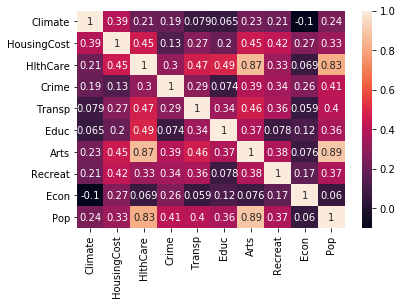

In [6]:
#посмотрим, коррелируют ли наши признаки
import seaborn as sns
sns.heatmap(data.corr(), annot = True)

Заметим, что большинство признаков коррелируют между собой, что негативно влияет на кластерный анализ, поэтому следует либо удалить наиболее коррелирующие, либо использовать расстояние Махалонобиса (либо я, прочитав 100500 статей неправильно понял). Выбрано использовать расстояние Махалонобиса.

In [7]:
def plot_boxplots(data):
    fig, axes = plt.subplots(2,5, figsize = (30,10))
    for idx, col in enumerate(data.columns):
        data.boxplot(column=col,ax = axes[idx//5,idx%5])

def plot_density(data):
    fig, axes = plt.subplots(2,5, figsize = (30,10))
    for idx, col in enumerate(data.columns):
        sns.distplot(data[col], ax = axes[idx//5,idx%5])

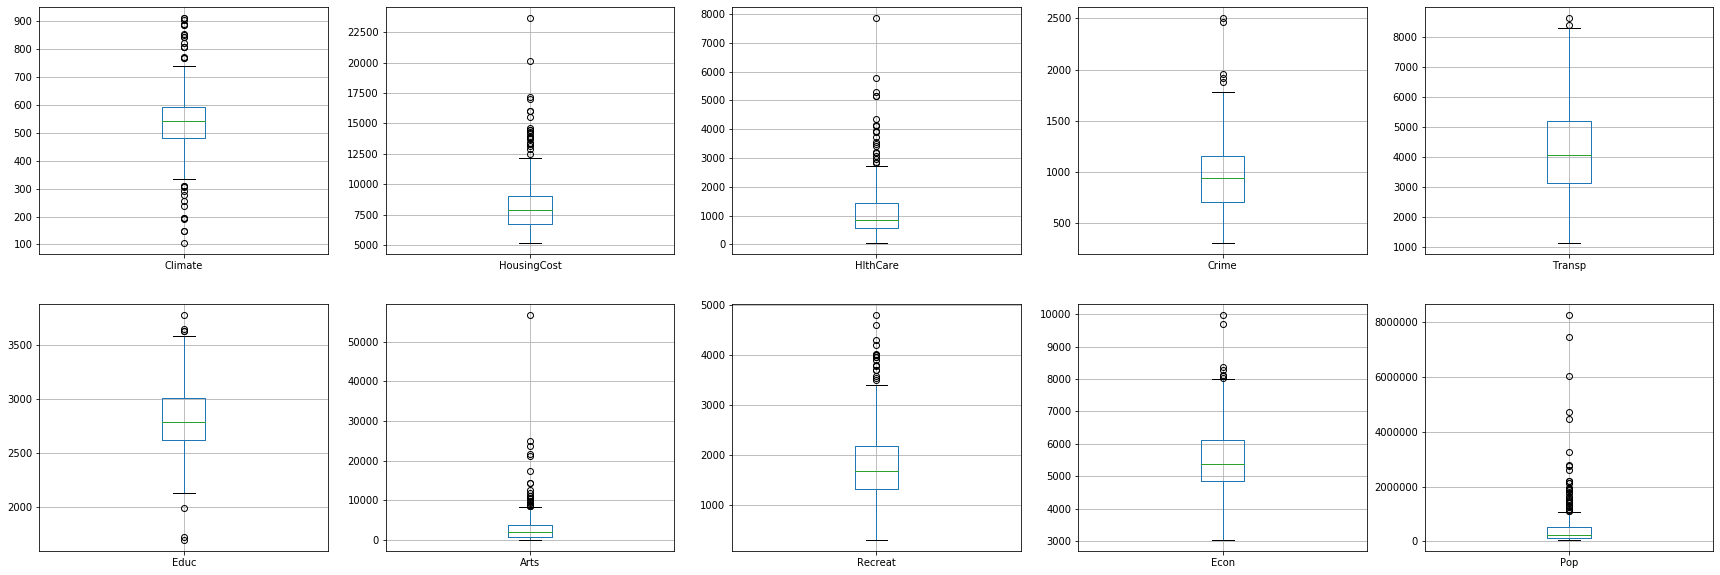

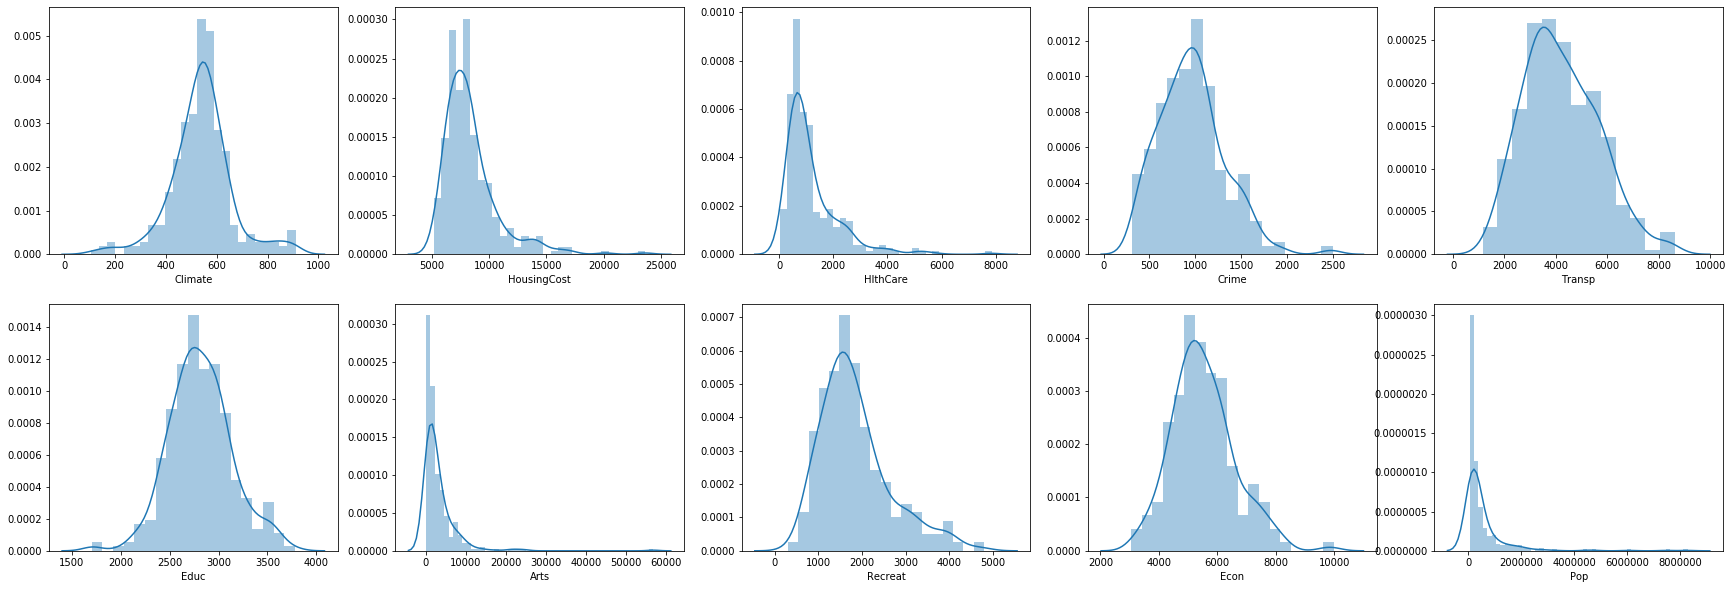

In [8]:
# посмотрим распределения признаков
plot_boxplots(data)
plot_density(data)

Заметим достаточно большое количество выбросов и что признаки Arts и HlthCare имеют распределение, похожее на геометрическое, что усложняет работу с данными

In [9]:
#уберем выбросы
def cutoff(df, sigma = 3):
    return df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < sigma).all(axis=1)]
data = cutoff(data, sigma = 3)
data.shape

(304, 10)

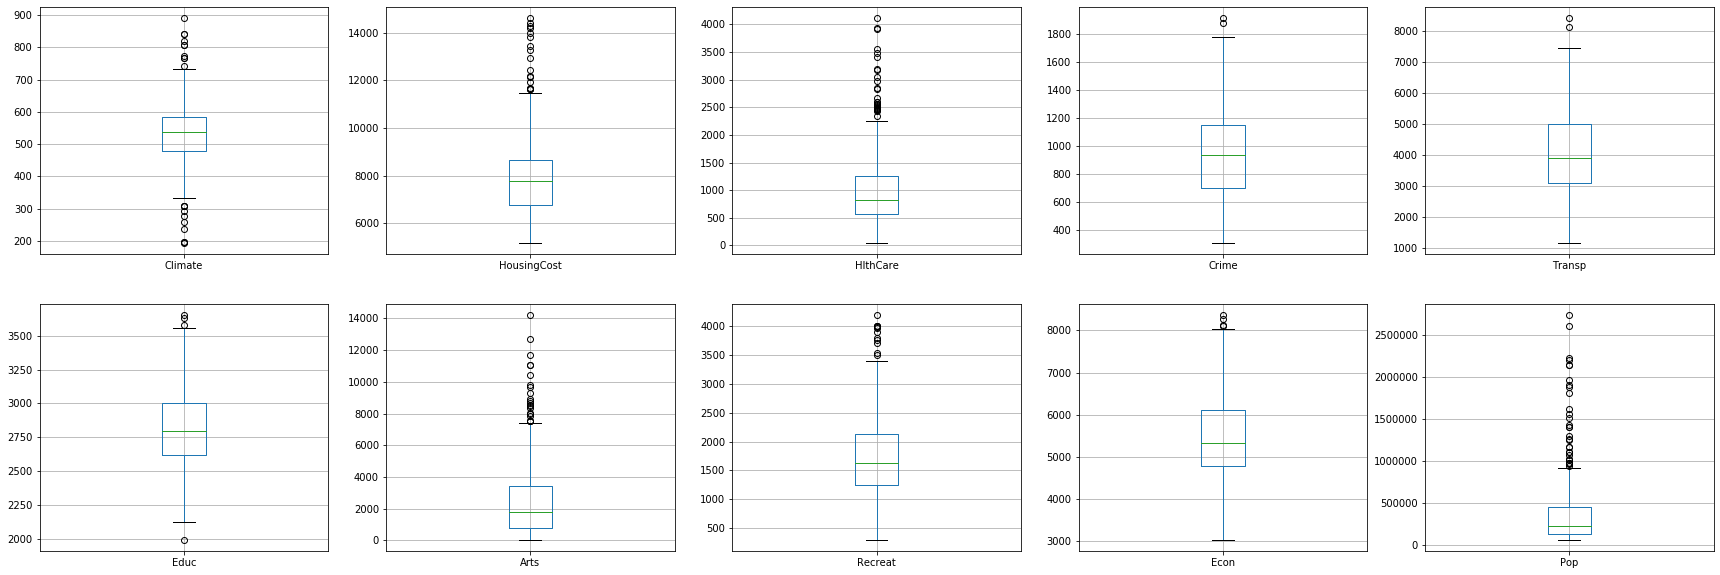

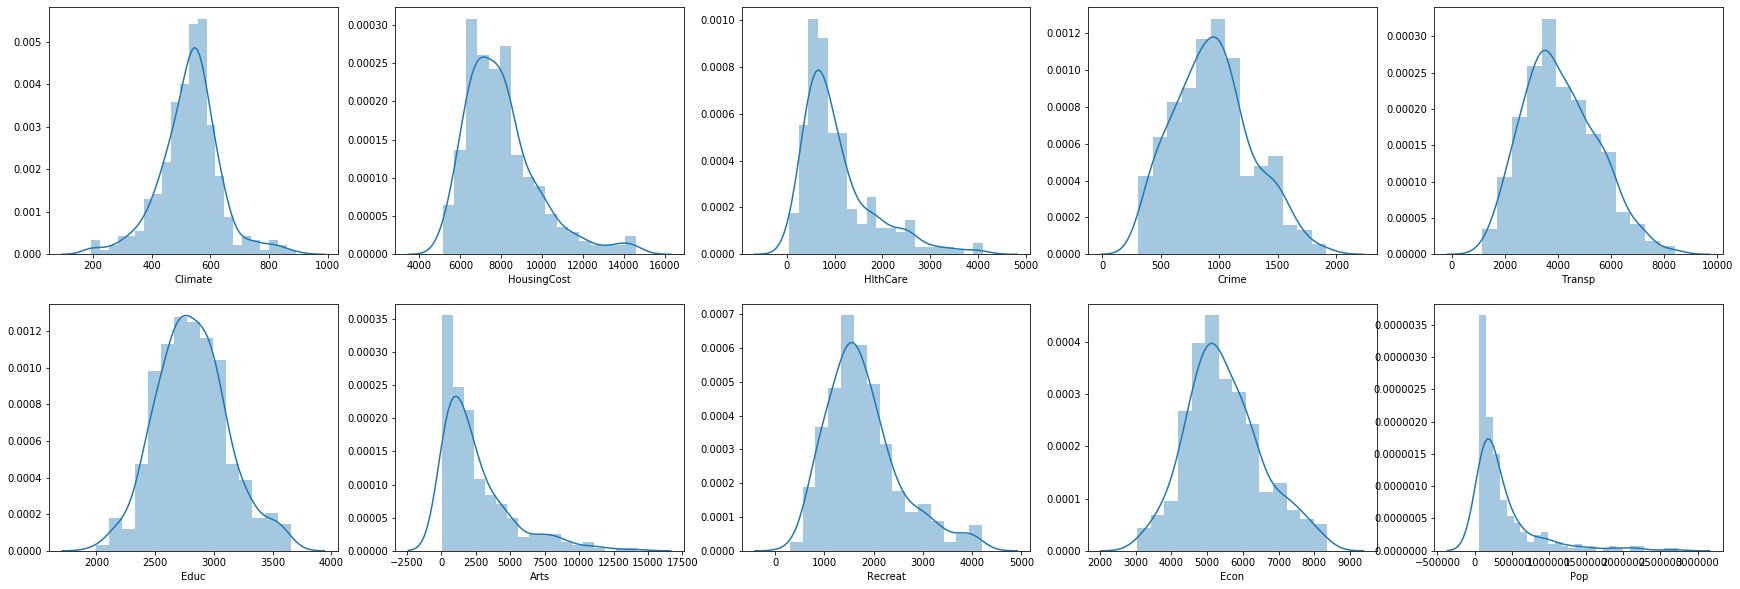

In [10]:
plot_boxplots(data)
plot_density(data)

Предварительный анализ показал, что оптимально убрать строки, в которых какой либо из параметров не входит в интервал 3 сигм. Это убирает всего 7 % данных, но, как видно из графиков, убираются большее число выбросов. Однако, обрезание итогового интервала до 2 сигм убирает 27 % данных, что, неприемлимо.

In [11]:
# нормируем данные
from sklearn.preprocessing import PowerTransformer
data[:] = PowerTransformer(method='box-cox').fit_transform(data)

Были испробованы все способы скалирования данных, StandartScaler и MinMax сильно зависили от выбросов, RobustScaler давал хороший результат, но не корректировал данные к нормальному распределению. + несколько статей в которых наблюдалась такая же проблема утверждали использовать PowerTransformer ^_^

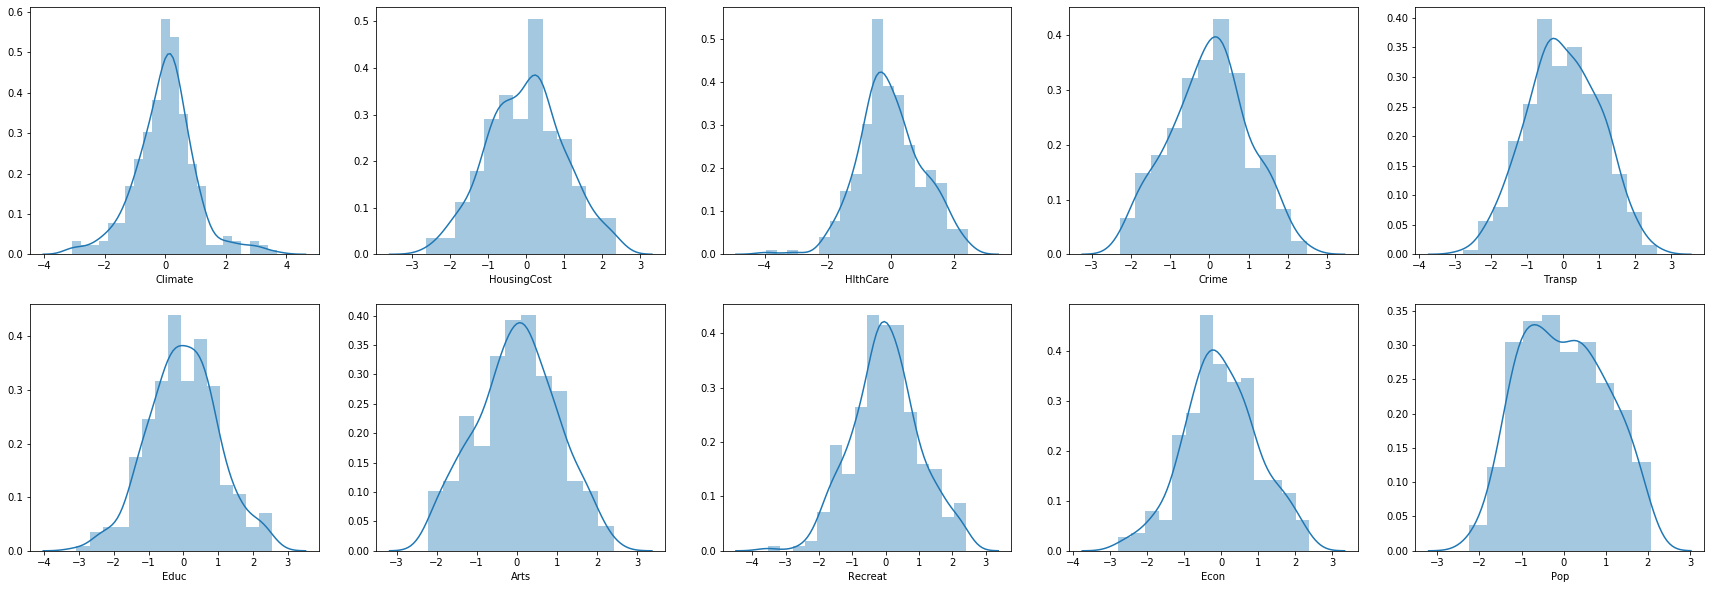

In [12]:
plot_density(data)

In [13]:
#Функция снижения размерности
from sklearn.decomposition import PCA
def transform_data_dimensions(data, n_comp ):
    return PCA(n_components = n_comp).fit_transform(data)

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

#плоттеры 2D и 3D кластеров

def plot_3D_cluster(data, color, fig, title='my_beautiful_plot', axes = 111, azim=-45, elev=30):
    ax = fig.add_subplot(axes, projection='3d', azim = azim, elev = elev)
    ax.set_title(title)
    ax.scatter([el[0] for el in data], [el[1] for el in data], [el[2] for el in data], c = color)
    
        
def plot_2D_cluster(data,color,fig, title='my_beautiful_plot',axes = 111):
    ax = fig.add_subplot(axes)
    ax.set_title(title)
    ax.scatter([el[0] for el in data], [el[1] for el in data], c = color)

In [15]:
# трансформируем данные до 3хмерного и 2хмерного пространства
data_reduced_3D = transform_data_dimensions(data, 3)
data_reduced_2D = transform_data_dimensions(data, 2)

427.9882603200652
371.44818551507325
336.6241129823933
314.86676820181856
244.3839082827681
222.27141231595388


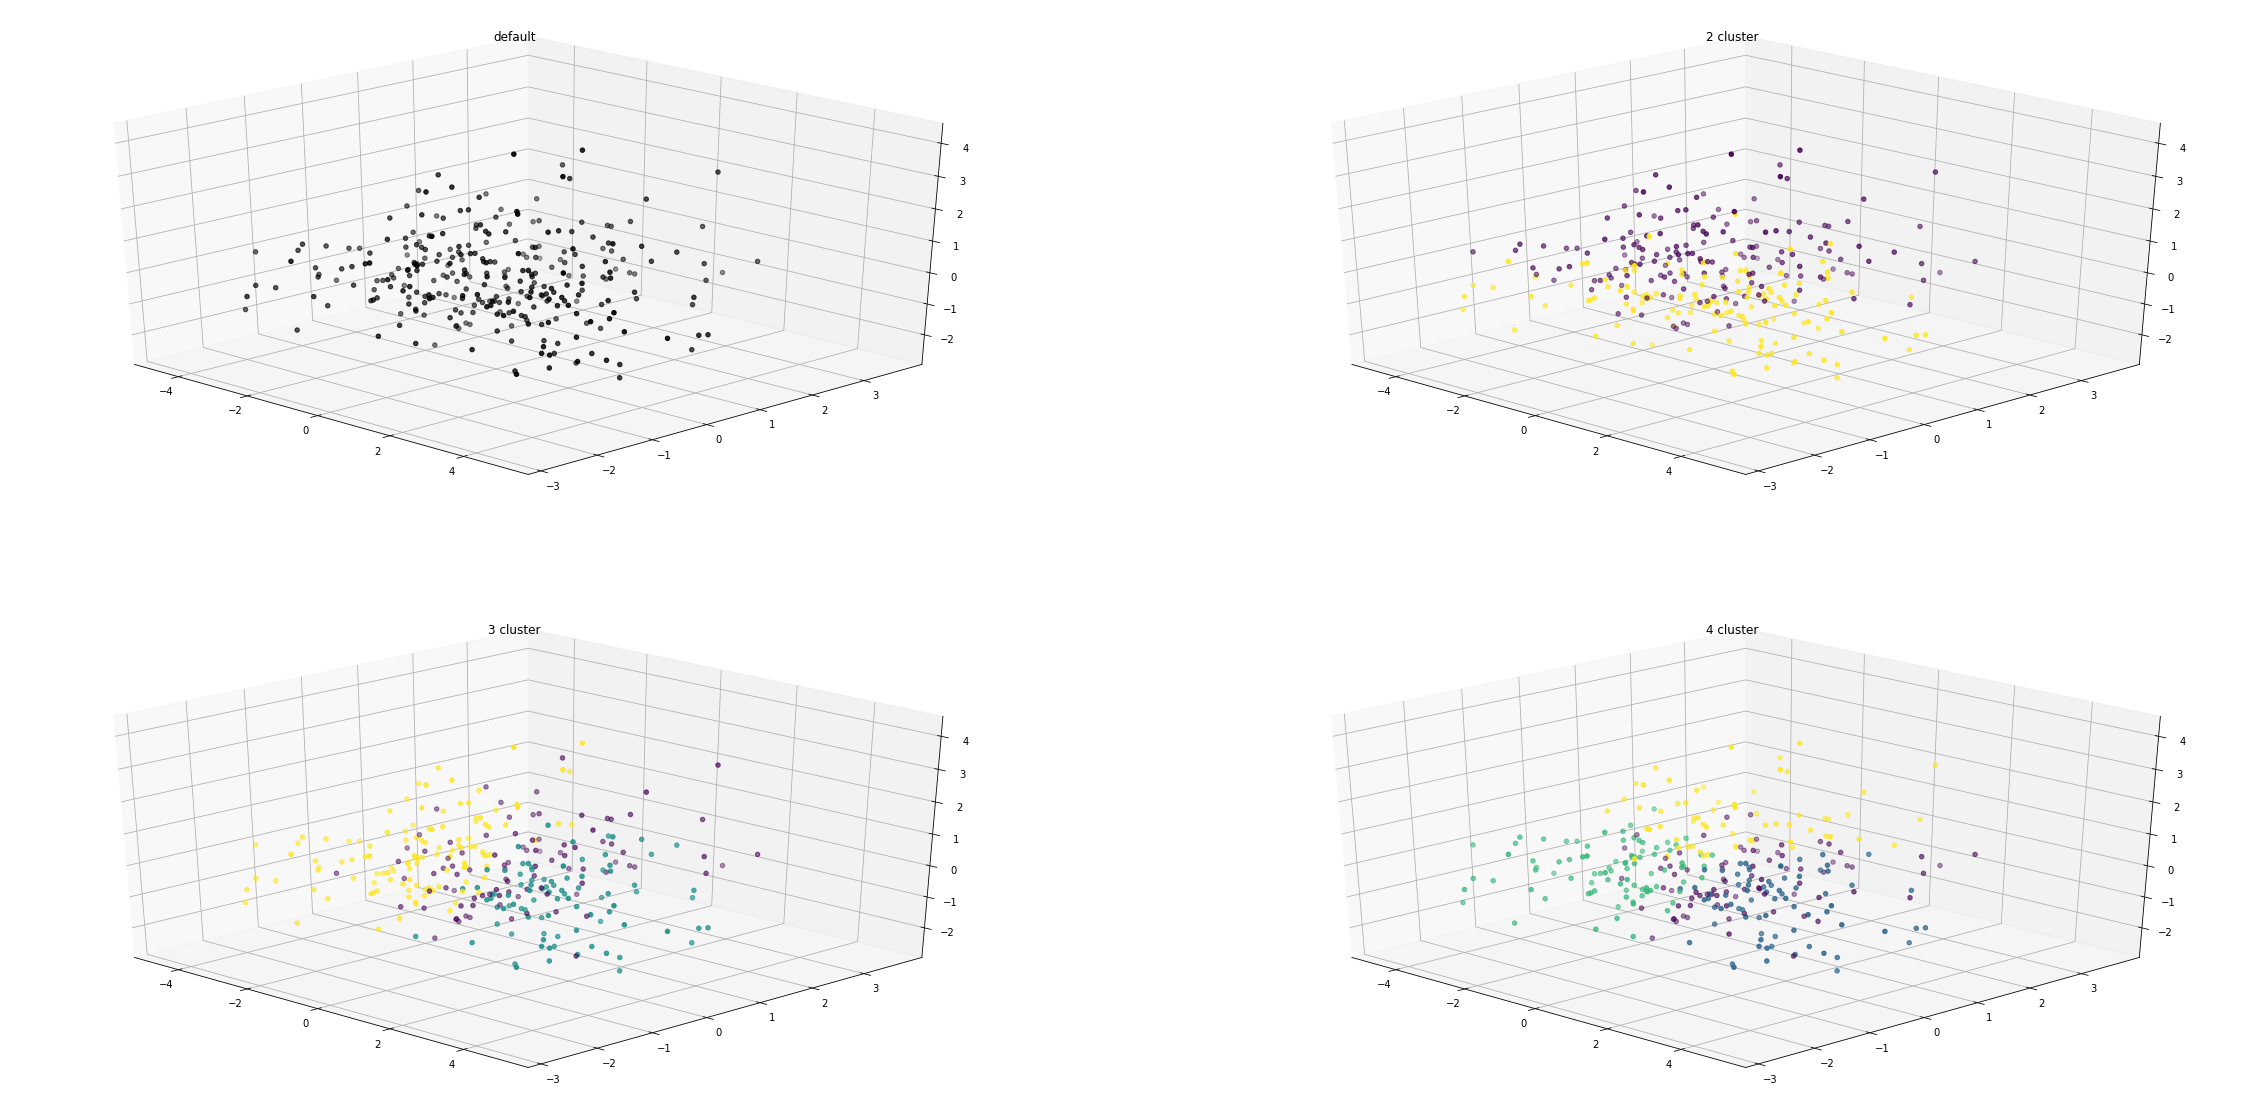

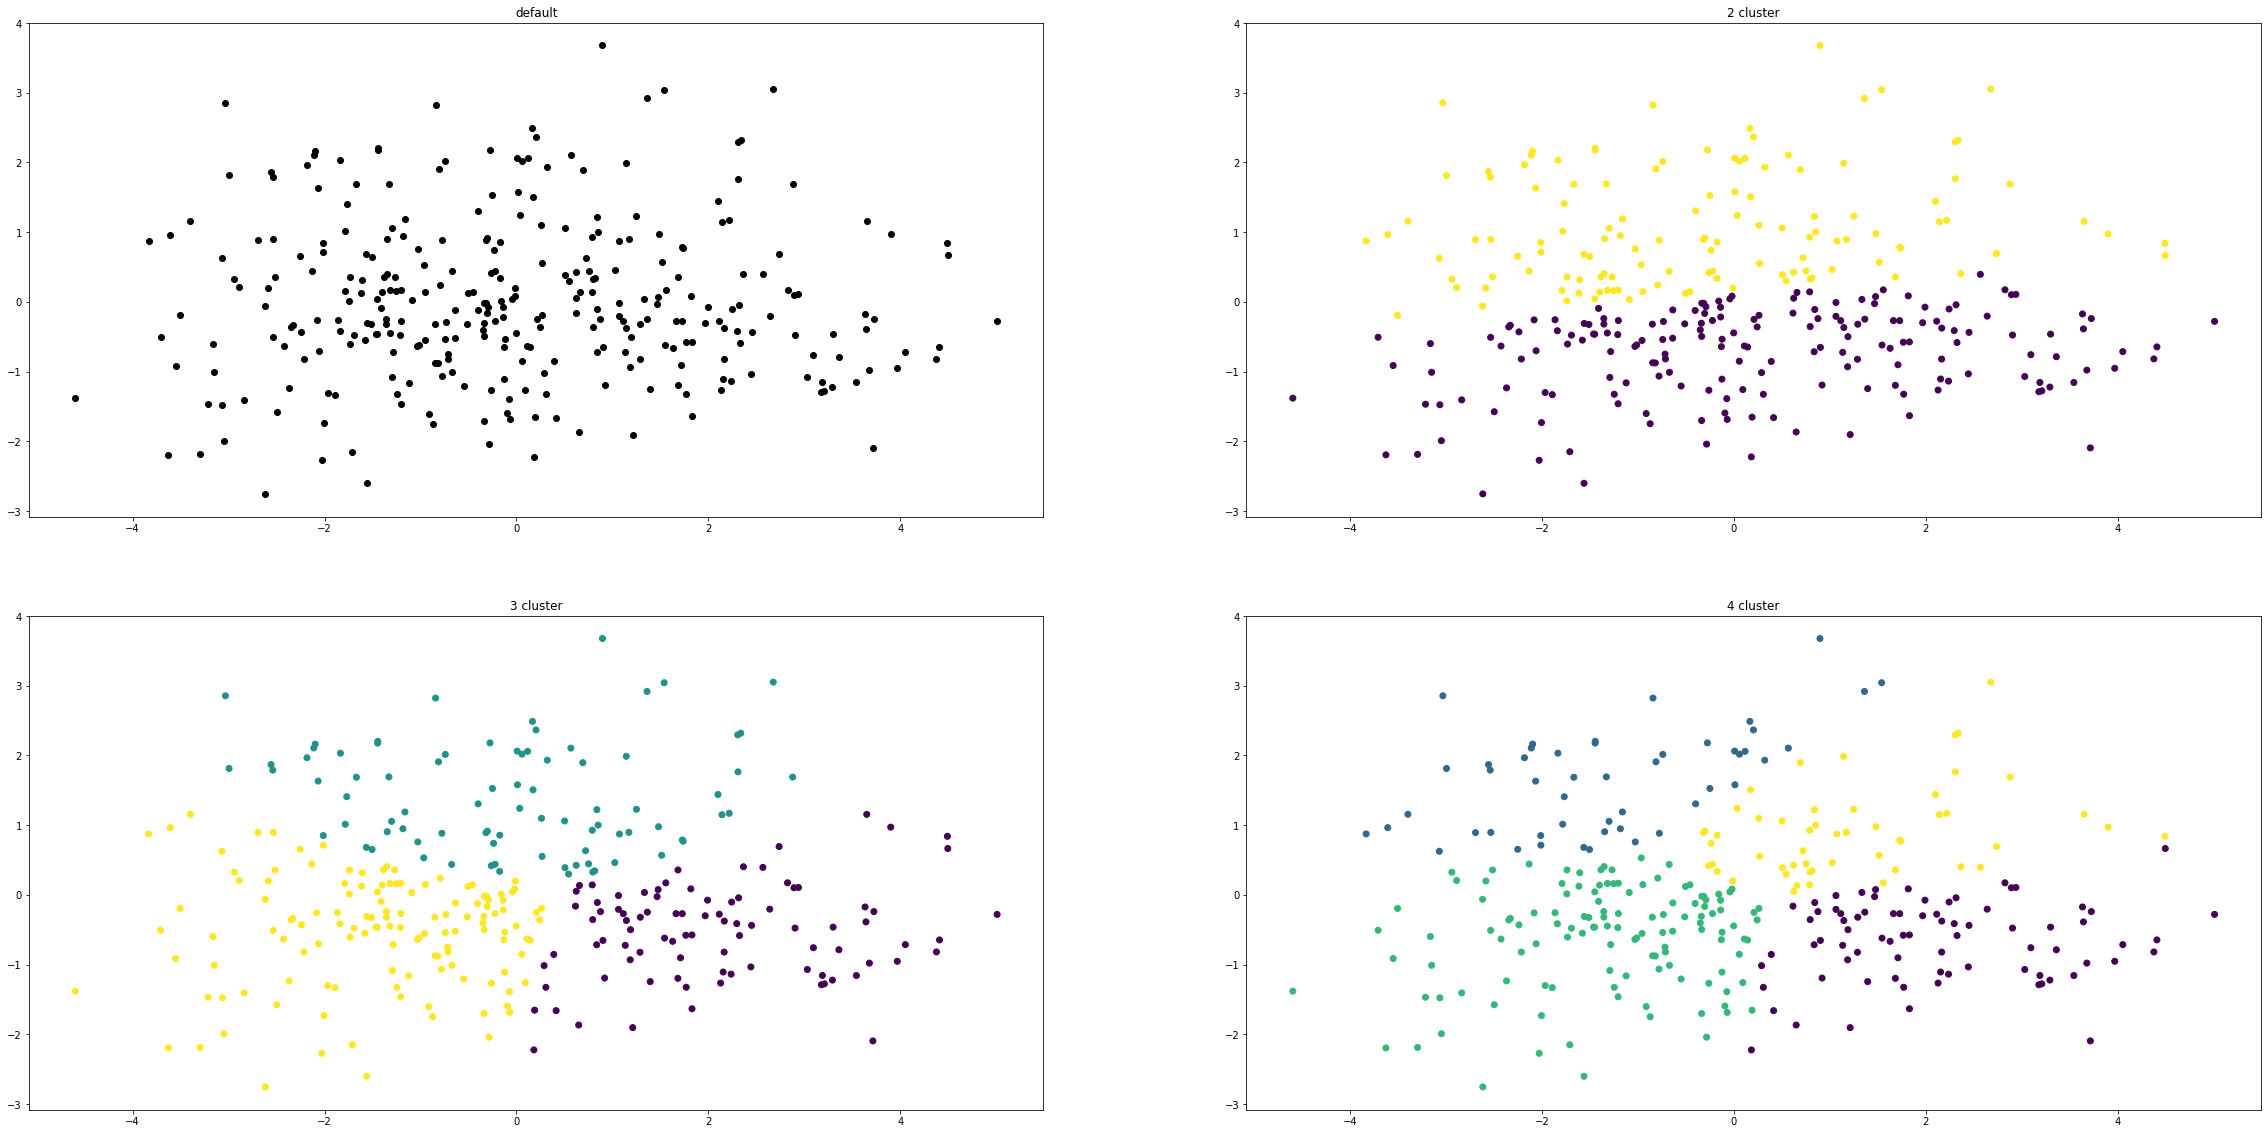

In [16]:
from sklearn_extra.cluster import KMedoids
#рассмотрим графики и попробуем определить количество кластеров "на глаз"

fig = plt.figure(figsize = (40,20))
plot_3D_cluster(data_reduced_3D, 'black', fig, axes = 221, title = 'default')

km = KMedoids(n_clusters=2, metric = 'mahalanobis')
km.fit_predict(data_reduced_3D)
plot_3D_cluster(data_reduced_3D, km.labels_, fig, axes = 222, title = '2 cluster')
print(km.inertia_)

km = KMedoids(n_clusters=3, metric = 'mahalanobis')
km.fit_predict(data_reduced_3D)
plot_3D_cluster(data_reduced_3D, km.labels_, fig, axes = 223, title = '3 cluster')
print(km.inertia_)

km = KMedoids(n_clusters=4, metric = 'mahalanobis')
km.fit_predict(data_reduced_3D)
plot_3D_cluster(data_reduced_3D, km.labels_, fig, axes = 224, title = '4 cluster')
print(km.inertia_)


fig = plt.figure(figsize = (40,20))
plot_2D_cluster(data_reduced_2D, 'black', fig, axes = 221, title = 'default')

km = KMedoids(n_clusters=2, metric = 'mahalanobis')
km.fit_predict(data_reduced_2D)
plot_2D_cluster(data_reduced_2D, km.labels_, fig, axes = 222, title = '2 cluster')
print(km.inertia_)

km = KMedoids(n_clusters=3, metric = 'mahalanobis')
km.fit_predict(data_reduced_2D)
plot_2D_cluster(data_reduced_2D, km.labels_, fig, axes = 223, title = '3 cluster')
print(km.inertia_)

km = KMedoids(n_clusters=4, metric = 'mahalanobis')
km.fit_predict(data_reduced_2D)
plot_2D_cluster(data_reduced_2D, km.labels_, fig, axes = 224, title = '4 cluster')
print(km.inertia_)

Визуальный анализ позволяет сделать предположение, что данные разделены на 3-4 кластера, либо вовсе не имеют кластерной структуры

1. Выполните кластеризацию иерархическим методом.  
Рассмотрите различные расстояния между объектами. Определите, какие следует использовать при кластеризации.  
Выполните кластеризацию с различными расстояниями между кластерами. Сравните результаты, сделайте выводы.  
<br> 

In [17]:
import scipy.cluster.hierarchy as hier

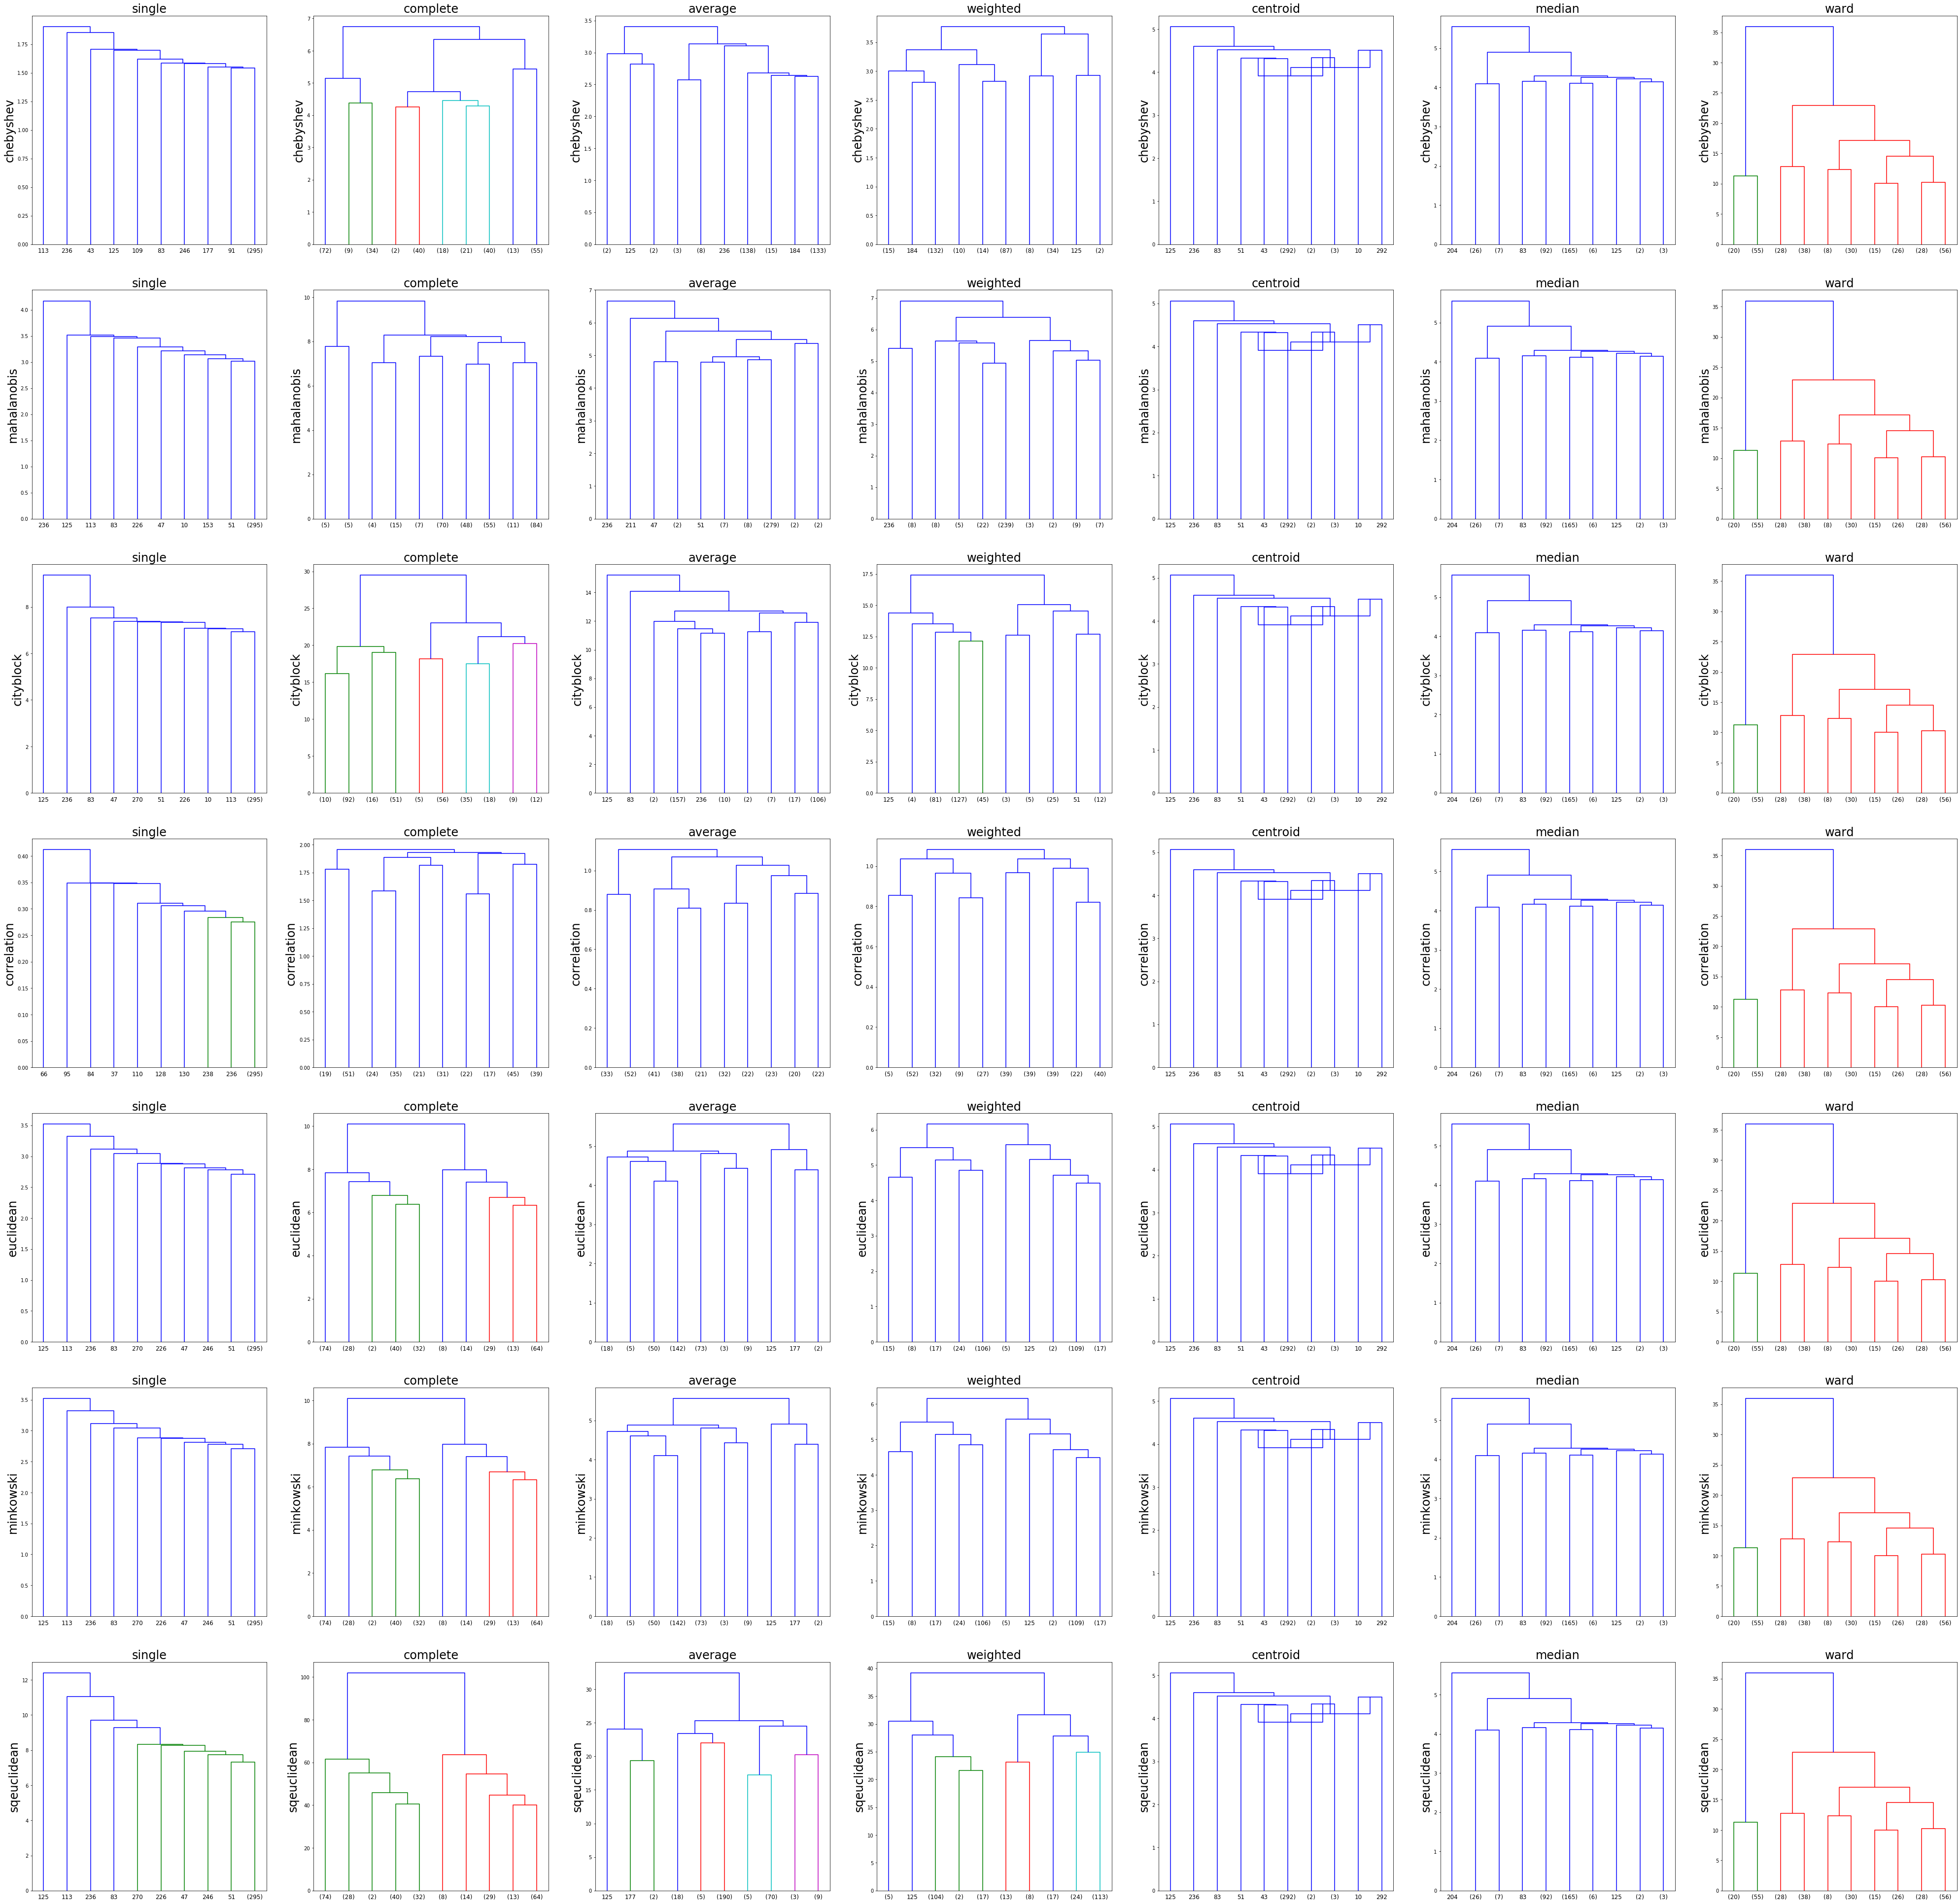

In [18]:
#Произведем иерархическую кластеризацию на таблице с 10 признаками (исходной стандартизованной)
clust_distances = ['single', 'complete', 'average','weighted','centroid','median','ward']
obj_distances = [
    'chebyshev',
    'mahalanobis',
    'cityblock', 
    'correlation', 
    'euclidean', 
    'minkowski',
    'sqeuclidean', 
]

f, axes = plt.subplots(len(obj_distances), len(clust_distances), figsize=(70,70))

for i, clust_distance in enumerate(clust_distances):
    for j, obj_distance in enumerate(obj_distances):
        Z = hier.linkage(data, method = clust_distance, metric = obj_distance if clust_distance not in ['median','centroid','ward'] else 'euclidean')
        
        axes[j,i].set_title(clust_distance,fontdict={'fontsize': 24})
        axes[j,i].set_ylabel(obj_distance,fontdict={'fontsize': 24})
        _ = hier.dendrogram(Z, p = 10, truncate_mode='lastp', ax = axes[j,i])
        


Практически все комбинации указывают, что данные составляют один кластер. Complete и Ward показались наиболее правильными, посмотрим их далее. Метрика mahalanobis будет использоваться далее по упомянутым ранее причинам.

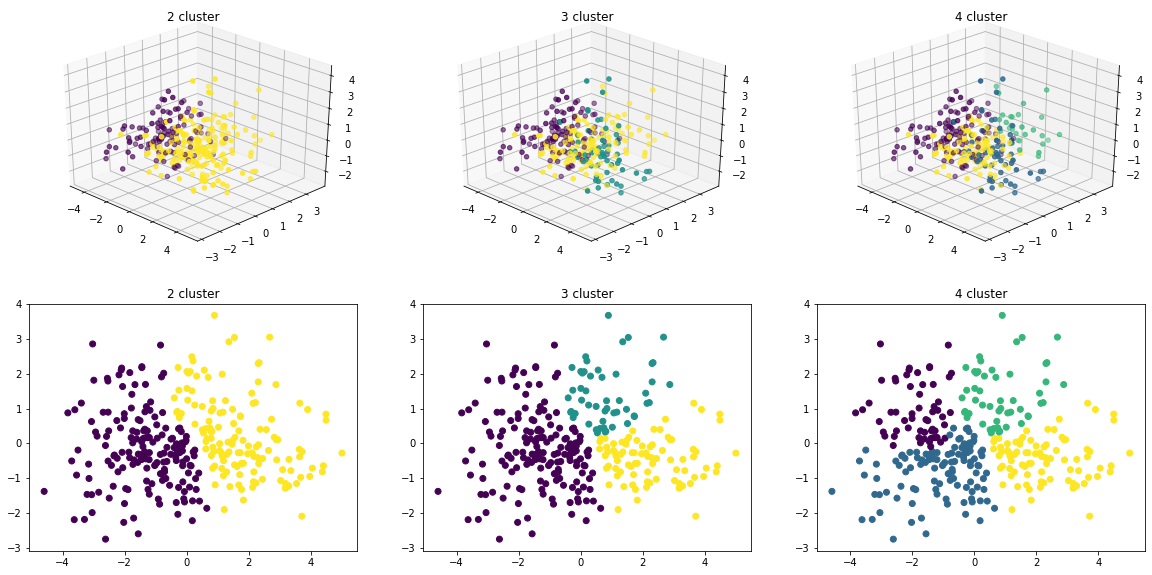

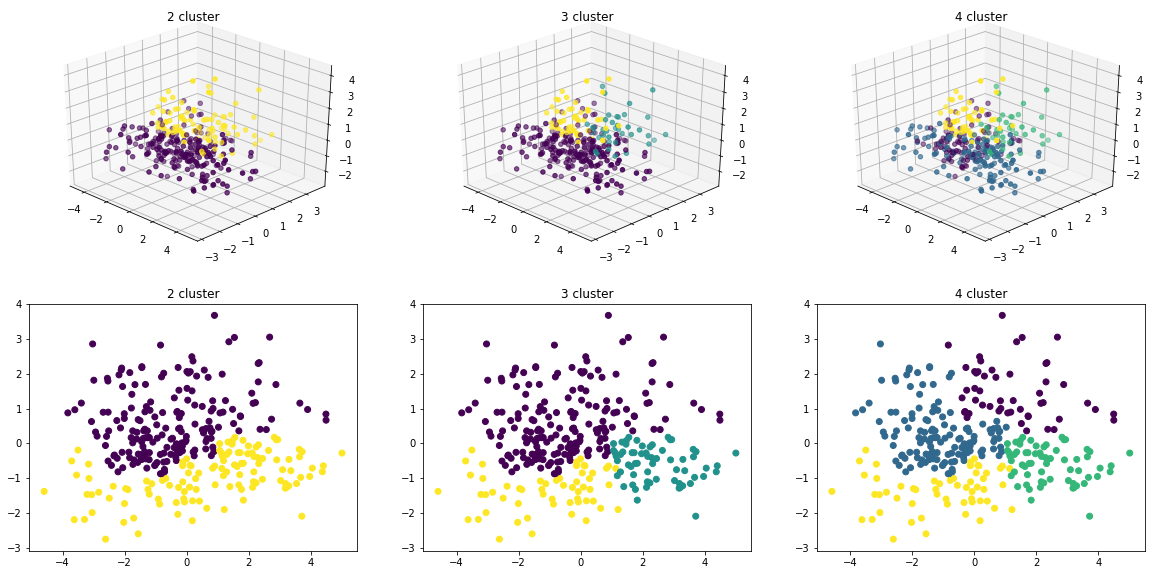

In [19]:
c_sizes = [2, 3, 4]

#ward
fig = plt.figure(figsize=(20,10))
for i, t in enumerate(c_sizes):
    Z = hier.linkage(data_reduced_3D, method = 'ward')
    labels = hier.fcluster(Z, t=t, criterion='maxclust')
    plot_3D_cluster(data_reduced_3D, labels, fig, axes = 230 + i + 1, title = str(t) + ' cluster')

    Z = hier.linkage(data_reduced_2D, method = 'ward')
    labels = hier.fcluster(Z, t=t, criterion='maxclust')
    plot_2D_cluster(data_reduced_2D, labels, fig, axes = 230 + i + 4, title = str(t) + ' cluster')

#complete
fig = plt.figure(figsize=(20,10))
for i, t in enumerate(c_sizes):
        Z = hier.linkage(data_reduced_3D, method = 'complete', metric = 'mahalanobis')
        labels = hier.fcluster(Z, t=t, criterion='maxclust')
        plot_3D_cluster(data_reduced_3D, labels, fig, axes = 230 + i + 1, title = str(t) + ' cluster')
        
        Z = hier.linkage(data_reduced_2D, method = 'complete', metric = 'mahalanobis')
        labels = hier.fcluster(Z, t=t, criterion='maxclust')
        plot_2D_cluster(data_reduced_2D, labels, fig, axes = 230 + i + 4, title = str(t) + ' cluster')
        

Анализ показал, что все варианты имеют шансы на существование, однако Ward выглядит более успешным.

2. Выполните кластеризацию методом dbscan. Используйте расстояния между объектами, определенные в предыдущем пункте.  
Реализуйте эвристику (см. лекции) для выбора параметров алгоритма. Подберите подходящие параметры алгоритма.  
<br>  

In [20]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import DBSCAN

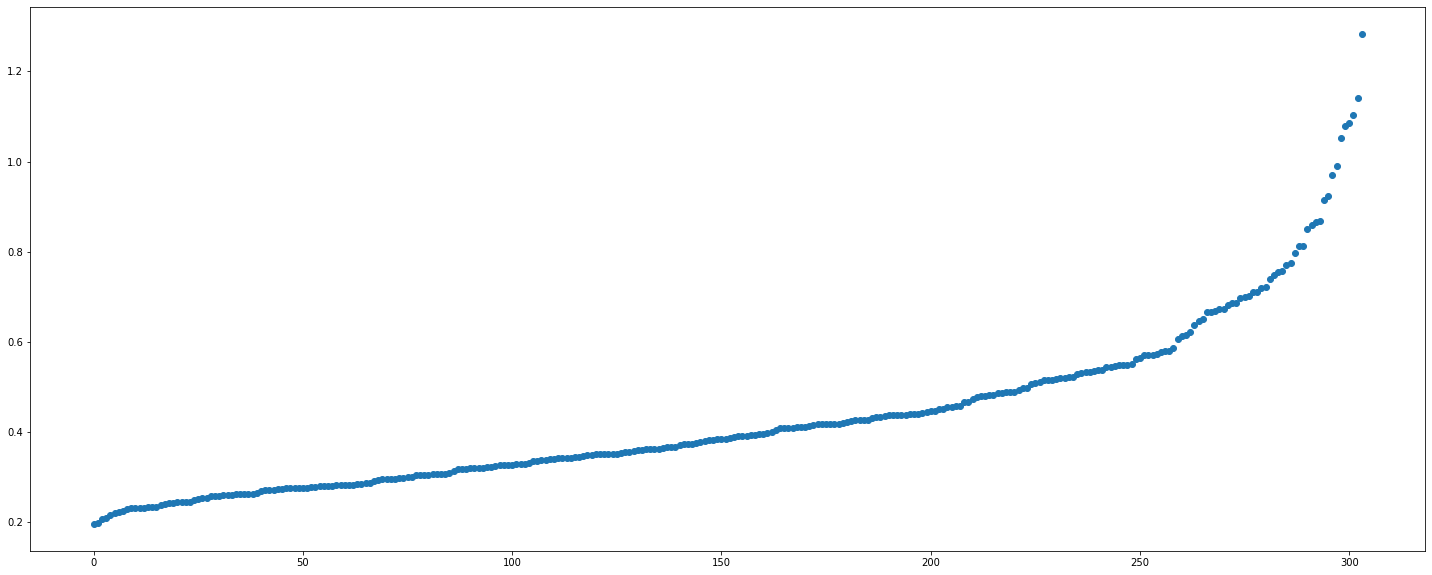

In [21]:
covariance = {'V': np.cov(data_reduced_3D, rowvar=False)}

model = NearestNeighbors(n_neighbors = 6, metric = 'mahalanobis', metric_params= covariance, algorithm = 'auto')
model.fit(data_reduced_3D)


dist, _ = model.kneighbors(data_reduced_3D, n_neighbors = 6, return_distance = True)
dist = np.sort([np.mean(d) for d in dist])
fig = plt.figure(figsize = [25,10])
plt.scatter(range(len(dist)), dist)

Соответственно графику функция начинает стремительно возрастать при значении ~ 0.6-0.8 = eps

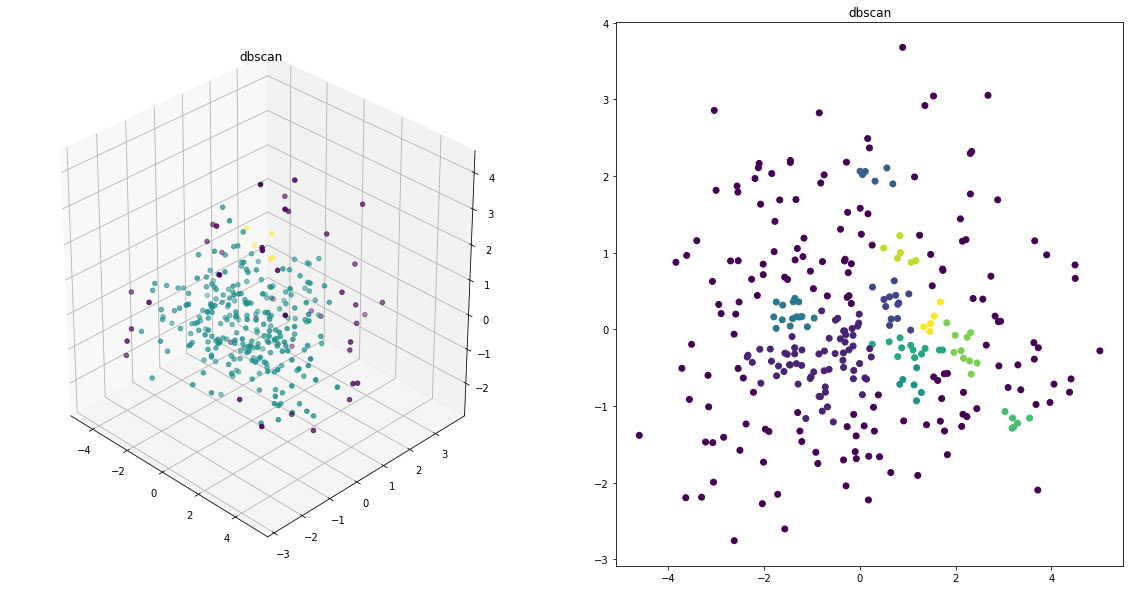

In [22]:
db = DBSCAN(eps=0.7, min_samples=6, metric='mahalanobis', metric_params = covariance).fit(data_reduced_3D)
fig = plt.figure(figsize=(20,10))
plot_3D_cluster(data_reduced_3D, db.labels_, fig, title = 'dbscan', axes = 121)

db = DBSCAN(eps=0.2, min_samples=6, metric='mahalanobis', metric_params = {'V': np.cov(data_reduced_2D, rowvar=False)}).fit(data_reduced_2D)
plot_2D_cluster(data_reduced_2D, db.labels_, fig, title = 'dbscan', axes = 122)

DBSCAN объеденил все в 1 большой кластер. При переборе параметров изменить результат не удалось

3. Выполните кластеризацию методом kmeans. Определите наилучшее (на ваш взгляд) число кластеров.  
<br>  

1098.5820826700492
897.4203760632223
761.379726277202
753.5827828887041
565.7529481936365
432.21589926537297


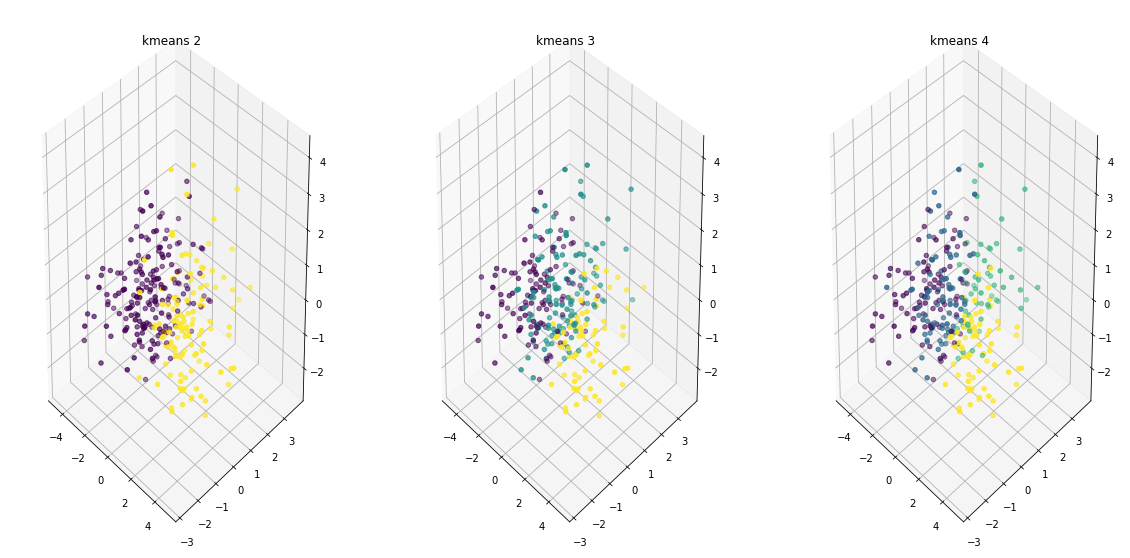

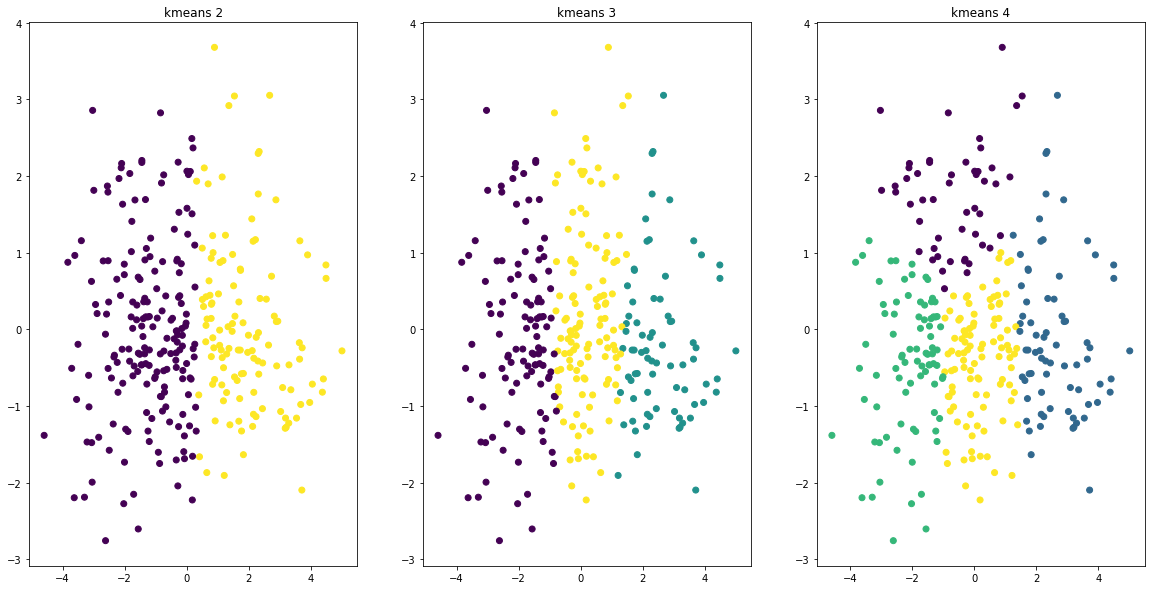

In [23]:
from sklearn.cluster import KMeans

fig = plt.figure(figsize=(20,10))
kmeans = KMeans(n_clusters=2).fit(data_reduced_3D)
plot_3D_cluster(data_reduced_3D, kmeans.labels_, fig, title = 'kmeans 2', axes = 131)
print(kmeans.inertia_)


kmeans = KMeans(n_clusters=3).fit(data_reduced_3D)
plot_3D_cluster(data_reduced_3D, kmeans.labels_, fig, title = 'kmeans 3', axes = 132)
print(kmeans.inertia_)

kmeans = KMeans(n_clusters=4).fit(data_reduced_3D)
plot_3D_cluster(data_reduced_3D, kmeans.labels_, fig, title = 'kmeans 4', axes = 133)
print(kmeans.inertia_)

fig = plt.figure(figsize=(20,10))
kmeans = KMeans(n_clusters=2).fit(data_reduced_2D)
plot_2D_cluster(data_reduced_2D, kmeans.labels_, fig, title = 'kmeans 2', axes = 131)
print(kmeans.inertia_)

kmeans = KMeans(n_clusters=3).fit(data_reduced_2D)
plot_2D_cluster(data_reduced_2D, kmeans.labels_, fig, title = 'kmeans 3', axes = 132)
print(kmeans.inertia_)

kmeans = KMeans(n_clusters=4).fit(data_reduced_2D)
plot_2D_cluster(data_reduced_2D, kmeans.labels_, fig, title = 'kmeans 4', axes = 133)
print(kmeans.inertia_)

Kmeans выделил 3 кластера лучше

4. Выполните кластеризацию методом PAM. Используйте расстояния между объектами, определенные в пункте (1). Определите наилучшее (на ваш взгляд) число кластеров.  
Используйте реализацию алгоритма из Задания 1.  
<br>  

419.9071855853268
369.4744945029536
334.10941968162115
299.1126645492919
242.02641267581296
217.77429103362127


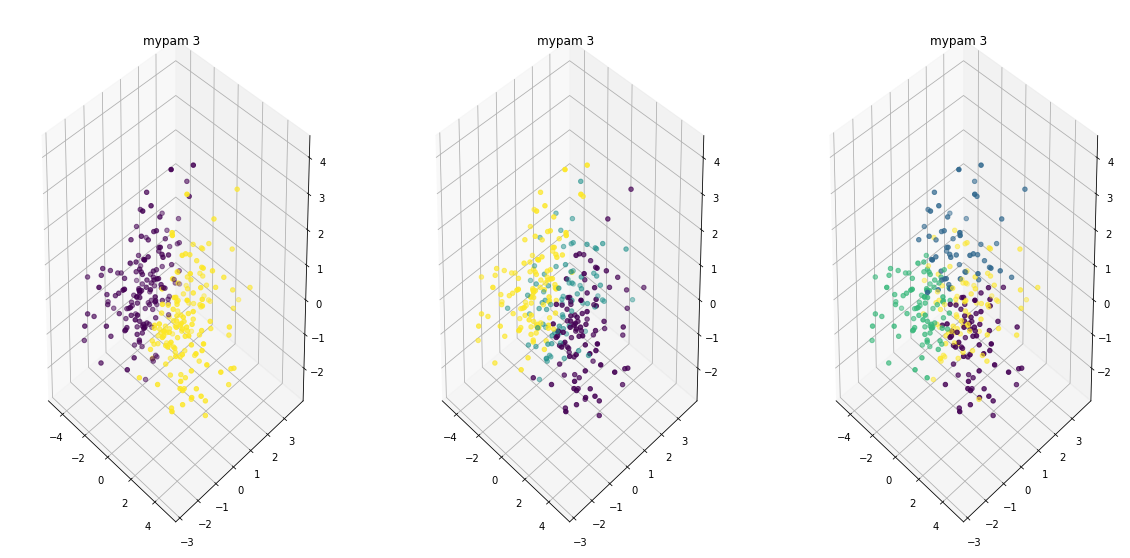

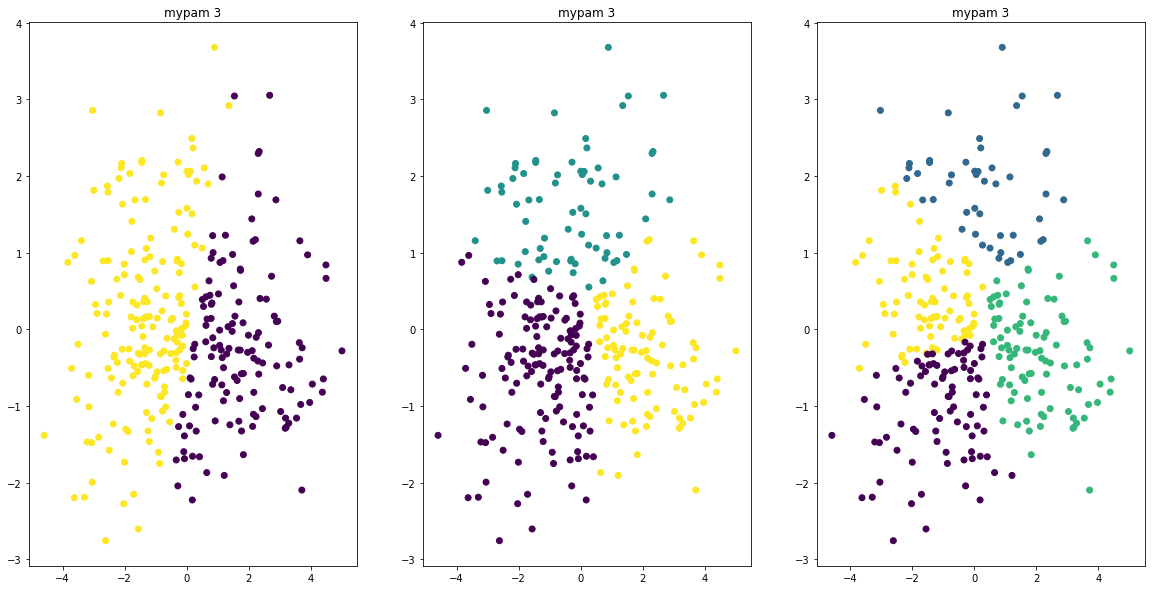

In [24]:

fig = plt.figure(figsize=(20,10))

for i, k in enumerate([2,3,4]):    
    p = pam (k = k, max_iter = 100, tol = 0, metric = 'mahalanobis')
    inertia_, centers_, labels_ = p.fit(data_reduced_3D)
    plot_3D_cluster(data_reduced_3D, labels_, fig, title = 'mypam 3', axes = 130 + i + 1)
    print(inertia_)

fig = plt.figure(figsize=(20,10))
for i, k in enumerate([2,3,4]):    
    p = pam (k = k, max_iter = 100, tol = 0, metric = 'mahalanobis')
    inertia_, centers_, labels_ = p.fit(data_reduced_2D)
    plot_2D_cluster(data_reduced_2D, labels_, fig, title = 'mypam 3', axes = 130 + i + 1)
    print(inertia_)

PAM отлично определил кластер размера 3, именно этот кластер будет импользоваться в качестве отображения результатов на карте Америки

5. (Бонусное) Выполните кластеризацию другими методами. Например, [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) или алгоритмы, [реализованные](https://scikit-learn.org/stable/modules/clustering.html) в scikit-learn.  
<br>  

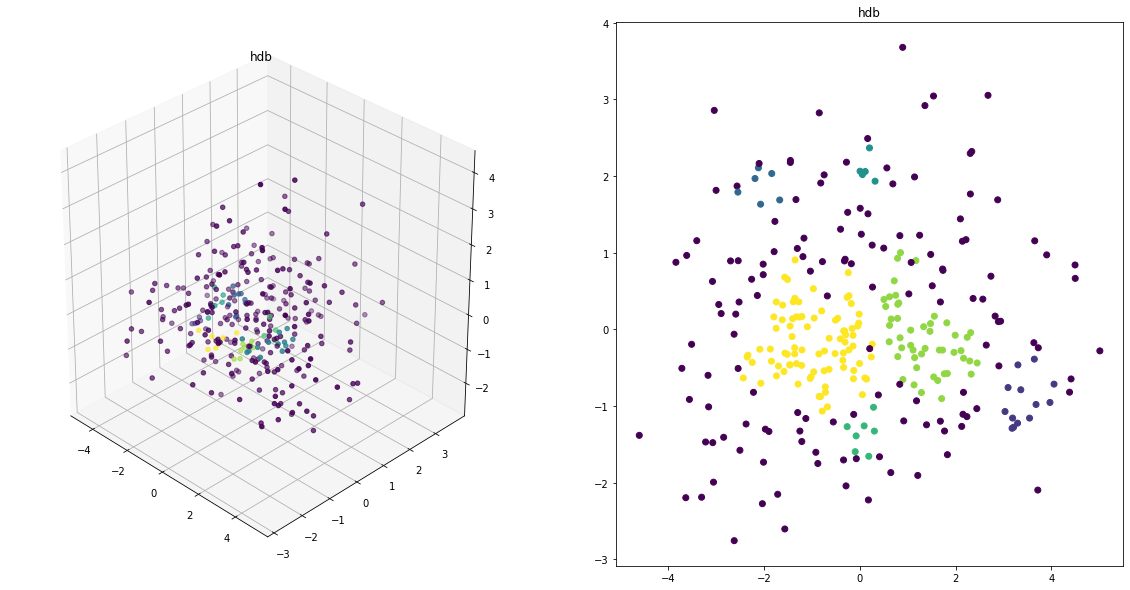

In [25]:
import hdbscan

hdb = hdbscan.HDBSCAN().fit(data_reduced_3D)
fig = plt.figure(figsize=(20,10))
plot_3D_cluster(data_reduced_3D, hdb.labels_, fig, title = 'hdb',axes=121)

hdb = hdbscan.HDBSCAN().fit(data_reduced_2D)
plot_2D_cluster(data_reduced_2D, hdb.labels_, fig, title = 'hdb', axes = 122)

Как и в случает с dbscan, из-за того, что в данных много шумов и выбросов, HDBSCAN плохо определил кластеры.

6. В результате выполнения предыдущих пунктов вы должны получить 4 или больше разбиения объектов (по одному на каждый метод). Сравните их между собой, сделайте выводы о сходствах и различиях.  
Оцените результаты каждой кластеризации, используя метрики, рассмотренные на занятиях (Silhouette и прочие).  
<br> 

Kmeans, Kmedoids и Hierarchical Ward алгоритмы выделили примерно одинаковые кластеры на 2D и 3D данных в случае числа кластеров = 3 и 4. DBscan и HDBscan нашли большое число выбросов. DBscan определил 1 кластер как оптимальный, HDBscan - 6, однако визуально число кластеров выделилось неверно.

Выберем самые лучшие разбиения из каждого метода кластеризации и рассчитаем silhouette coef:

In [26]:
from sklearn.metrics import silhouette_score

for i in range(2,7):
    labels = hier.fcluster(hier.linkage(data_reduced_3D, method = 'ward'), t=i, criterion='maxclust')
    print("Hier ward score {} clust:".format(i),silhouette_score(data_reduced_3D, labels))


labels = DBSCAN(eps=0.7, min_samples=6, metric='mahalanobis', metric_params = {'V': np.cov(data_reduced_3D, rowvar=False)}).fit_predict(data_reduced_3D)
try:
    print("DBSCAN score:", silhouette_score(data_reduced_3D, labels))
except:
    print("DBSCAN score undefined because there is only 1 cluster")
    
    
labels = hdbscan.HDBSCAN().fit(data_reduced_3D).labels_
print("HDBSCAN score :", silhouette_score(data_reduced_3D, labels))


for i in range(2,7):
    labels = KMeans(n_clusters=i).fit(data_reduced_3D).labels_
    print("Kmeans score {} clust:".format(i), silhouette_score(data_reduced_3D, labels))

for i in range (2,7):
    _, _, labels = pam (k = i, max_iter = 100, tol = 0, metric = 'mahalanobis').fit(data_reduced_3D)
    print("PAM score {} clust:".format(i), silhouette_score(data_reduced_3D, labels))

Hier ward score 2 clust: 0.2953631267461531
Hier ward score 3 clust: 0.22347757030279555
Hier ward score 4 clust: 0.2299566766973166
Hier ward score 5 clust: 0.21821513424774874
Hier ward score 6 clust: 0.21466242959645984
DBSCAN score: 0.0816968184384737
HDBSCAN score : -0.3651576810818893
Kmeans score 2 clust: 0.3497375280190816
Kmeans score 3 clust: 0.24958264340377154
Kmeans score 4 clust: 0.23597483923947193
Kmeans score 5 clust: 0.2535121375320623
Kmeans score 6 clust: 0.26486474248880526
PAM score 2 clust: 0.3056740374372741
PAM score 3 clust: 0.26286054542022713
PAM score 4 clust: 0.2204560764735123
PAM score 5 clust: 0.22421053035780406
PAM score 6 clust: 0.2279341519261091


Оказалось, что наиболее вероятное количество кластеров оказалось равным 2 ( экстремум ). Однако было выявлено, что при числе кластеров = 2 1 кластер имеет все значения выше чем другой, что, с одной стороны, может быть правдой, но с другой стороны, разбиение на 3 кластера оказалось чуть более интересным.

7. Выберите одно разбиение, наиболее подходящее на ваш взгляд. Предложите интерпретацию полученным кластерам или покажите, что этого сделать нельзя.  
<br>  

In [27]:
info_data = pd.read_csv('Data.txt', sep=' ')
extra_data = info_data[["Place","Long","Lat"]]
info_data.drop(columns = ['Place','Lat','Long'], inplace = True)
info_data = cutoff(info_data)
info_data = info_data.assign(Place = None, Long = None, Lat=None)

for i in data.index:
    info_data.loc[i,'Place']= extra_data.loc[i, 'Place']
    info_data.loc[i,'Long']= extra_data.loc[i, 'Long']
    info_data.loc[i,'Lat']= extra_data.loc[i, 'Lat']

In [28]:
info_data

Climate  HousingCost  HlthCare  Crime  Transp  Educ  Arts  Recreat  Econ  \
0        521         6200       237    923    4031  2757   996     1405  7633   
1        575         8138      1656    886    4883  2438  5564     2632  4350   
2        468         7339       618    970    2531  2560   237      859  5250   
3        476         7908      1431    610    6883  3399  4655     1617  5864   
4        659         8393      1853   1483    6558  3026  4496     2612  5727   
..       ...          ...       ...    ...     ...   ...   ...      ...   ...   
324      562         8715      1805    680    3643  3299  1784      910  5040   
325      535         6440       317   1106    3731  2491   996     2140  4986   
326      540         8371       713    440    2267  2903  1022      842  4946   
327      570         7021      1097    938    3374  2920  2797     1327  3894   
328      608         7875       212   1179    2768  2387   122      918  4694   

        Pop                       Place     Long      Lat  
0    110932                  Abilene,TX  -99.689   32.559  
1    660328                    Akron,OH  -81.518   41.085  
2    112402                   Albany,GA  -84.158   31.575  
3    835880  Albany-Schenectady-Troy,NY -73.7983  42.7327  
4    419700              Albuquerque,NM  -106.65   35.083  
..      ...                         ...      ...      ...  
324  402918                Worcester,MA  -71.795   42.272  
325  172508                   Yakima,WA -120.513   46.595  
326  381255                     York,PA  -76.728    39.96  
327  531350        Youngstown-Warren,OH  -80.729    41.17  
328  101979                Yuba-City,CA -121.622   39.128  

[304 rows x 13 columns]

In [29]:
_, _, labels = pam (k = 3, max_iter = 100, tol = 0, metric = 'mahalanobis').fit(data_reduced_3D)

result = pd.DataFrame(index = range(3), columns = ['Climate','HousingCost','HlthCare','Crime','Transp','Educ','Arts','Recreat','Econ','Pop']) 
info_data = info_data.assign(label = labels)

for i in range (3):
    tmp = []
    for j, col in enumerate(result.columns):
        result.iloc[i, j] = np.mean(info_data[col].where(info_data['label'] == i))
result

Climate HousingCost HlthCare    Crime   Transp     Educ     Arts  Recreat  \
0  457.248     7915.03  751.257  1010.83  3892.46  2754.31  1569.94  1902.27   
1  579.958     7413.98  730.136  797.186  3599.48  2715.14  1318.51  1488.12   
2  559.234     9065.94  2017.12  1078.97  5154.96   3046.4  5786.34  2059.49   

      Econ     Pop  
0  6243.15  244140  
1   4712.2  217561  
2  5595.71  891425

Итого можно предположить, что кластеры разделились по уровню жизни. В кластер с индексом 2 попали преимущественно мегаполисы, что наблюдается по количеству населения, числу людей и развитости остальных признаков. Кластер с индексом 0, вероятно, составляют "академгородки" из за развитой сферы образования, ценой на жизнь и развитой экономикой. Кластер с индексом 1 составляют туристические города.

Но это, с вероятностью 99.99% неправда. Я перепробовал 100500 способов, но чего-то более-менее адекватного не получилось 

8. Оцените, как полученные кластеры распределены географически. (Бонусное) [Провизуализируйте](https://python-visualization.github.io/folium/quickstart.html) распределение на карте США.  
Оцените, как полученные кластеры распределены по штатам. Можно ли выделить какую-то зависимость (территориальную или для штатов)?

In [39]:
import folium
from folium.plugins import BeautifyIcon
m = folium.Map(location=[45.5236, -122.6750])

In [40]:
colors = ['green', 'lightgreen', 'darkgreen']
for i in range(info_data.shape[0]):
    folium.Marker([info_data.iloc[i]['Lat'],info_data.iloc[i]['Long']],
                        icon = BeautifyIcon(icon_shape='rectangle-dot', border_width=10, border_color = colors[labels[i]]),
                        popup = info_data.iloc[i,:].to_string()).add_to(m)

In [41]:
m

Карта качества жизни США

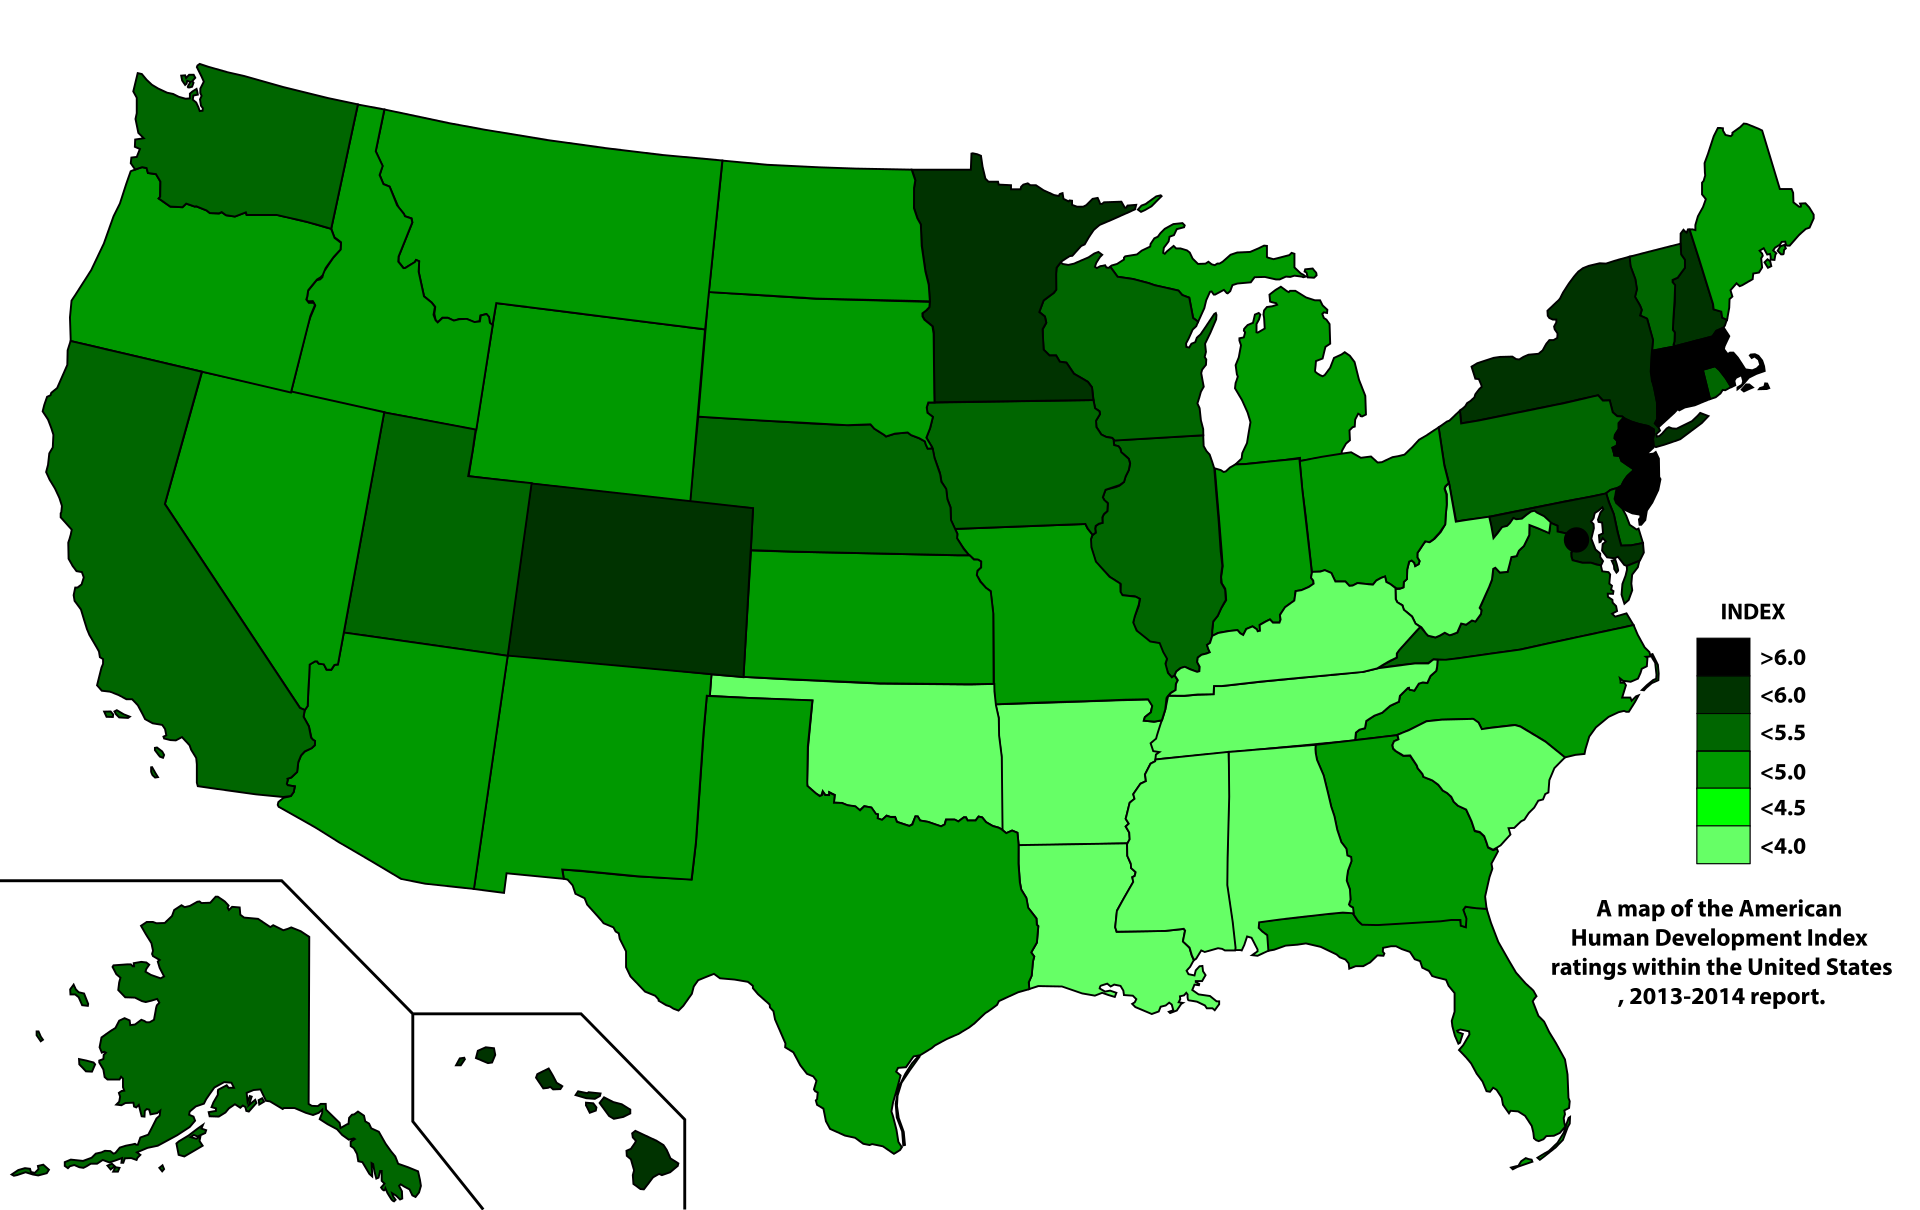

### Вывод: Хотя индекс качества жизни (цвет) в большинстве мест совпал с предписанными им кластерами, нет оснований утверждать, что кластеры выделились правильно, так как, как это было видно из графиков, данные образуют скорее 1 кластер.